# Traffic Sign Classification with Tensorflow


## Step 0: Load Image Dataset

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from zipfile import ZipFile
from PIL import Image
from IPython.display import HTML

import pickle
import os
import cv2
from tqdm import tqdm


# Define variables
setnames = ['train', 'test', 'valid']
data = dict({'train': [], 'test': [], 'valid': []})
X        = dict()
y        = dict()

path     = "/home/tiwi/Documents/mldata/traffic-signs-data_unzipped/"
#path     = "/home/tiwi/Documents/mldata/"
for setname in setnames:
    with open(path + setname + '.p', 'rb') as f:
        print("load dataset {}.p".format(setname))
        data[setname] = pickle.load(f)
print("Done.")

# Add real images to data container
with open('real_traffic_signs.pickle', 'rb') as f:  
    rdata = pickle.load(f)
setnames.append('real')
data['real'] = {'features': [], 'labels': []}
data['real']['features'] = rdata['real']['features']
data['real']['labels'] = rdata['real']['labels']


for setname in setnames:
    X[setname], y[setname] = data[setname]['features'], data[setname]['labels']
    

load dataset train.p
load dataset test.p
load dataset valid.p
Done.



## Step 1: Print Dataset Information

In [3]:
classes = pd.read_csv("../CarND-Traffic-Sign-Classifier-Project/signnames.csv")
nb_classes = len(set(y["train"]))

print("Number of training examples:\t", X["train"].shape[0])
print("Number of testing examples:\t",  X["test"].shape[0])
print("Number of validation examples:\t",  X["valid"].shape[0])
print("Number of real examples:\t",  X["real"].shape[0])
print("Image data shape:\t\t",          X["train"].shape[1:])
print("Number of classes:\t\t",         nb_classes)
print(classes)

Number of training examples:	 34799
Number of testing examples:	 12630
Number of validation examples:	 4410
Number of real examples:	 6
Image data shape:		 (32, 32, 3)
Number of classes:		 43
    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next in

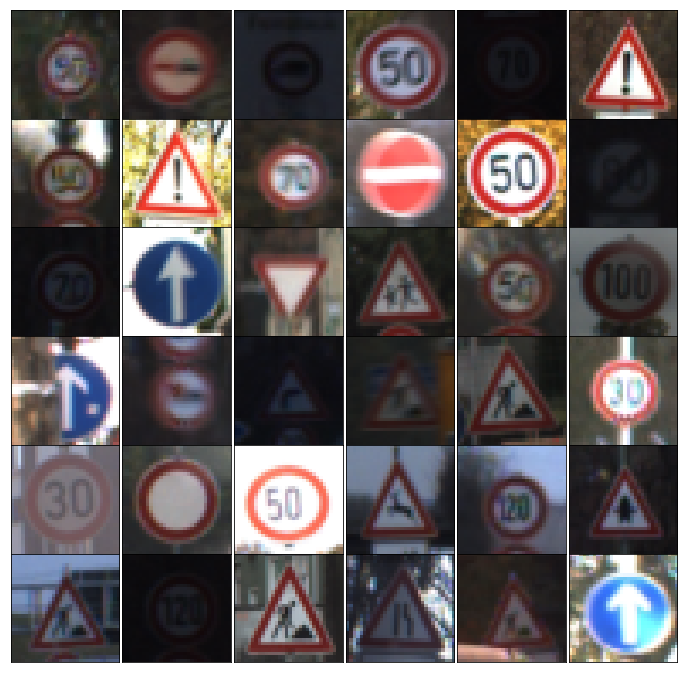

In [4]:
def plot_traffic_signs(X, rnd_seed=1):
    
    # Define square number of example images
    n = np.int(np.floor(np.sqrt(nb_classes)))
    nb_plots = n**2
    np.random.seed(rnd_seed)
    random_images = [X["train"][i,::] for i in np.random.randint(0, X["train"].shape[0], nb_plots)]

    # Setup a grid [n x n] grid of subplots
    fig, axes = plt.subplots(n, n, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for img, ax, img_class in zip(random_images, axes.flat, classes["SignName"][0:nb_plots]):
        if img.shape[-1] < 3:
            ax.imshow(img.squeeze())
        else:
            ax.imshow(img)

        
    plt.show()
plot_traffic_signs(X)

## Step 2: Design and Test a Model Architecture
The basic idea is to implement a simple CNN archictecture that gets a reasonable accurancy. 

### Preprocessing 1: Normalization

In [5]:
print("Before Normalization")
print("Shape:\t", X["train"].shape)
print("Min:\t", X["train"].min())
print("Max:\t", X["train"].max())
print("Mean:\t", np.mean(X["train"]))

print("Shape y:", y["train"].shape)

Before Normalization
Shape:	 (34799, 32, 32, 3)
Min:	 0
Max:	 255
Mean:	 82.677589037
Shape y: (34799,)


In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder

def normalize_brightness(features):
    equ = dict()
    for key in features: 
        sx, sy = features[key].shape[1], features[key].shape[2] 
        equ[key] = np.zeros((features[key].shape[0:3]))
        for idx, img in enumerate(features[key]):
            tmp_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            tmp_img = cv2.equalizeHist(tmp_img)
            equ[key][idx,:,:] = tmp_img
        equ[key] = equ[key].reshape(-1, sx, sy, 1)
        print(equ[key].shape)
        
    return equ

def normalize(features, method='standard'):
    X = features.copy()
    if method=='standard':
        scaler = StandardScaler()
    elif method=='norm':
        scaler = Normalizer()
    elif method=='minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
        
    for key in X:
        shape      = X[key].shape
        image_size = shape[1] * shape[2] * shape[3]    
        X[key]     = X[key].reshape(-1, image_size)
        X[key]     = scaler.fit_transform(np.float32(X[key])).reshape(-1, shape[1], shape[2], shape[3])
    return X

def encode(labels):
    y = labels.copy()
    nb_classes = len(set(y["train"]))
    encoder = OneHotEncoder(sparse=False)

    for key in y:
        y[key] = encoder.fit_transform(y[key].reshape(-1, 1))
    return y



def get_batches(features, labels, batch_size):
    nb_samples = len(features)
    split_at = np.arange(batch_size, nb_samples, batch_size)
    
    features, labels = shuffle(features, labels)
    
    feature_batches = np.split(features, split_at)
    label_batches   = np.split(labels, split_at)
    
    return feature_batches, label_batches

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)
(6, 32, 32, 1)

After Normalization
Shape:	 (34799, 32, 32, 1)
Min:	 0.0
Max:	 1.0
Mean:	 0.515054
Shape y: (34799,)
Shape Y: (34799, 43)
Type Y: <class 'numpy.ndarray'>


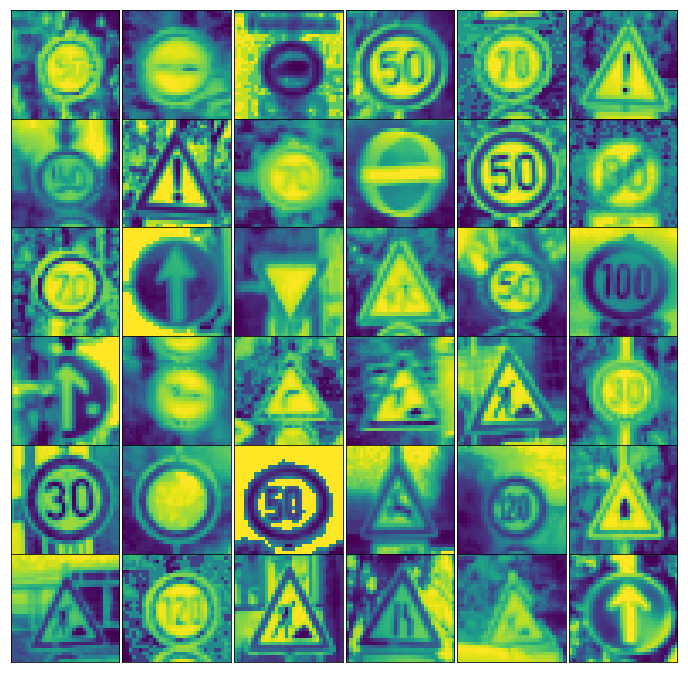

In [7]:
X = normalize_brightness(X)
X = normalize(X, method='minmax')
Y = encode(y)

print("\nAfter Normalization")
print("Shape:\t", X["train"].shape)
print("Min:\t", X["train"].min())
print("Max:\t", X["train"].max())
print("Mean:\t", np.mean(X["train"]))

print("Shape y:", y["train"].shape)

print("Shape Y:", Y["train"].shape)
print("Type Y:", type(Y["train"]))

assert type(Y['train']) == type(X['train'])
assert len(Y['train']) == len(y['train'])

plot_traffic_signs(X)

### Model Architecture Design

In [8]:
def dense(x, nb_nodes, scope):
    
    return tf.contrib.layers.fully_connected(x, nb_nodes, activation_fn=None, scope=scope)

def dense_bn(x, nb_nodes, phase, scope):
    
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, nb_nodes, 
                                               activation_fn=None,
                                               scope='dense')
        
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        
        
        return tf.nn.relu(h2, 'relu')
    
def conv_bn(x, nb_filters, kernel_size, phase, activation='relu', stride=1, padding='SAME', scope='conv_nb'):
    
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.conv2d(x, nb_filters, kernel_size,
                                      stride=stride, padding=padding,
                                      activation_fn=None, scope='conv') 
        
        """
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
          """  
        if activation == None:
            return h1
        elif activation == 'relu':
            return tf.nn.relu(h1, 'relu')
    
def residuum_stack(x, nb_filters, kernel_size, phase, scope='res_stack'):
    
    input_size  = x.get_shape()[3]
    output_size = nb_filters
    #print("Sizes: ", input_size, output_size)

    with tf.variable_scope(scope):
        with tf.variable_scope('A'):
            h = conv_bn(x, nb_filters, kernel_size, phase, activation='relu', scope='conv_bn')
        with tf.variable_scope('B'):
            h = conv_bn(h, nb_filters, kernel_size, phase, activation='relu', scope='conv_bn')

        if input_size == output_size:
            shortcut = x
            #print("in==out:", shortcut.get_shape()[3], h.get_shape()[3])
            return tf.nn.relu(h + shortcut, 'relu')

        else:
            shortcut = tf.contrib.layers.conv2d(x,
                                            output_size,
                                            kernel_size=[1,1],
                                            activation_fn=None,
                                            scope='conv_1x1')
            """
            if input_size > output_size:
                print("in>out:", x.get_shape()[3], h.get_shape()[3])
            elif input_size < output_size:
                print("in<out:", x.get_shape()[3], h.get_shape()[3])

            """
            return tf.nn.relu(h + shortcut, 'relu')
        
def inception_A(x, phase, scope='block_A'):

    nb_filters_1 = 16
    nb_filters_2 = x.get_shape()[3]
    
    with tf.variable_scope(scope):
        with tf.variable_scope('branch_0'):            
            shortcut = x

        with tf.variable_scope('branch_1'):
            h1 = conv_bn(x, nb_filters_1, [1,1], phase, scope='conv_1_1x1')
            
        with tf.variable_scope('branch_2'):
            h2a = conv_bn(x,   nb_filters_1, [1,1], phase, scope='conv_2a_1x1')
            h2  = conv_bn(h2a, nb_filters_1, [3,3], phase, scope='conv_2b_3x3')
            
        with tf.variable_scope('branch_3'):
            h3a = conv_bn(x,   nb_filters_1, [1,1], phase, scope='conv_3a_1x1') 
            h3b = conv_bn(h3a, nb_filters_1, [3,3], phase, scope='conv_3b_3x3') 
            h3  = conv_bn(h3b, nb_filters_1, [3,3], phase, scope='conv_3c_3x3')
        h = conv_bn((h1+h2+h3), nb_filters_2, [1,1], phase, scope='conv_sum_1x1')
        return tf.nn.relu(shortcut + h, 'relu')
            
def inception_B(x, phase, scope='block_B'):

    nb_filters_1 = 32  #128
    nb_filters_2 = x.get_shape()[3]  

    with tf.variable_scope(scope):
        with tf.variable_scope('branch_0'):            
            shortcut = x

        with tf.variable_scope('branch_1'):
            h1 = conv_bn(x, nb_filters_1, [1,1], phase, scope='conv_1_1x1')
            
        with tf.variable_scope('branch_2'):
            h2a = conv_bn(x,   nb_filters_1, [1,1], phase, scope='conv_2a_1x1')
            h2b = conv_bn(h2a, nb_filters_1, [1,7], phase, scope='conv_2b_1x7')
            h2  = conv_bn(h2b, nb_filters_1, [7,1], phase, scope='conv_2c_7x1')
        h = conv_bn(h1+h2, nb_filters_2, [1,1], phase, scope='conv_sum_1x1')
        return tf.nn.relu(shortcut + h, 'relu')
        
def inception_C(x, phase, scope):
    
    nb_filters_1 = 64  # 192
    nb_filters_2 = x.get_shape()[3]  
    with tf.variable_scope(scope):
        with tf.variable_scope('branch_0'):
            shortcut = x
            
        with tf.variable_scope('branch_1'):
            h1  = conv_bn(x,   nb_filters_1, [1,1], phase, scope='conv_1_1x1')
    
        with tf.variable_scope('branch_2'):
            h2a  = conv_bn(x,   nb_filters_1, [1,1], phase, scope='conv_2a_1x1')
            h2b  = conv_bn(h2a, nb_filters_1, [1,3], phase, scope='conv_2b_1x3')
            h2   = conv_bn(h2b, nb_filters_1, [3,1], phase, scope='conv_2c_3x1')
        h   = conv_bn(h1+h2, nb_filters_2, [1,1], phase, scope='conv_sum_1x1')
        return tf.nn.relu(shortcut+h, 'relu')
    

In [9]:
tf.reset_default_graph()
x         = tf.placeholder('float32', (None, 32, 32, 1), name='x')
y_one_hot = tf.placeholder('float32', (None, nb_classes), name='y_one_hot')
phase     = tf.placeholder(tf.bool, name='phase')

h01 = conv_bn(x,   16,  [3, 3], phase, stride=1, scope='layer_h01')
h02 = residuum_stack(h01, 32,  [3, 3], phase, scope='layer_h02')
h04 = inception_A(h02, phase, 'layer_h04')
h05 = conv_bn(h04, 32, [3, 3], phase, stride=2, scope='layer_h05')
h06 = inception_B(h05, phase, 'layer_h06')
h07 = conv_bn(h06, 64, [3, 3], phase, stride=2, scope='layer_h07')
h08 = inception_C(h07, phase, 'layer_h08')
h0e = residuum_stack(h08, 16, [3, 3], phase, scope='layer_h0e')
h00 = tf.contrib.layers.flatten(h0e, scope='flatten')
fc1  = dense_bn(h00, 96, phase, scope='layer_fc1')
fc2  = tf.nn.dropout(fc1, 0.6, name='dropout')
logits = dense(fc2, nb_classes, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y_one_hot, 1), tf.argmax(logits, 1)),
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot))

prediction         = tf.nn.softmax(logits, name='prediction')
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
def evaluate(X_batches, Y_batches, accuracy_operation):
    
    total_accuracy   = 0
    nb_total_samples = 0
    sess = tf.get_default_session()
    
    for X_batch, Y_batch in zip(X_batches, Y_batches):
        accuracy = sess.run(accuracy_operation, feed_dict={x: X_batch,
                                                           y_one_hot: Y_batch,
                                                          phase: False})
        
        nb_samples        = len(Y_batch)
        total_accuracy   += (accuracy * nb_samples)
        nb_total_samples += nb_samples

    return total_accuracy / nb_total_samples


In [11]:
import pandas as pd

def train(nb_epochs, X_batches, Y_batches, X_valid_batches, Y_valid_batches, learning_rate):
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
    # Ensures that we execute the update_ops before performing the train_step
        train_step = tf.train.AdamOptimizer(lr).minimize(loss)
        
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        session.run(tf.global_variables_initializer())

        history = []
        model_improved = False
        print("Start training ...")
        for epoch in range(0, nb_epochs):
            X_batches, Y_batches = shuffle(X_batches, Y_batches)
            for X_batch, Y_batch in zip(X_batches, Y_batches):
                session.run(train_step, feed_dict={'x:0': X_batch, 
                                                   'y_one_hot:0': Y_batch, 
                                                   'phase:0': True})
            tr = session.run([loss, accuracy], 
                              feed_dict={'x:0': X_batch,
                                         'y_one_hot:0': Y_batch,
                                         'phase:0': True})

            acc = evaluate(X_valid_batches, Y_valid_batches, accuracy_operation)
            history += [[epoch] + tr + [acc]]
            if epoch > 0:
                model_improved = history[-1][3] > np.max(np.array(history[:-1])[:,3])
            print("EPOCH {0} {1} \tsaved checkpoint: {2}".format(epoch+1,
                                                                      history[-1],
                                                                      model_improved))
            if model_improved:
                # Save the variables to disk.
                save_path = saver.save(session, "/home/tiwi/Documents/mldata/model_checkpoints/model.ckpt")
    print("Done.")
    return pd.DataFrame(np.array(history), columns=('Epochs', 'Losses', 'TrainAcc', 'TestAcc'))

### Train the Model

In [12]:
nb_epochs  = 3
batch_size = 16
nb_samples = 10 * batch_size
lr         = 0.0005

X_batches, Y_batches = get_batches(X['train'][0:nb_samples,::],
                                   Y['train'][0:nb_samples,::],
                                   batch_size=batch_size)

X_test_batches, Y_test_batches = get_batches(X['test'][0:nb_samples,::],
                                   Y['test'][0:nb_samples,::],
                                   batch_size=batch_size)

X_valid_batches, Y_valid_batches = get_batches(X['valid'][0:nb_samples,::],
                                   Y['valid'][0:nb_samples,::],
                                   batch_size=batch_size)

#### The real training is performed on the AWS E2C instance.

In [202]:
history = train(nb_epochs, X_batches, Y_batches, X_test_batches, Y_test_batches, learning_rate=lr)

Start training ...
EPOCH 1 [0, 3.3940792, 0.1875, 0.0062500000000000003] 	saved checkpoint: False
EPOCH 2 [1, 2.6950593, 0.4375, 0.012500000000000001] 	saved checkpoint: True
EPOCH 3 [2, 2.3915825, 0.6875, 0.012500000000000001] 	saved checkpoint: False
Done.


### Save Training History

In [203]:
with open('training_history.pickle', 'wb') as f: 
    pickle.dump(history[:], f)

### Plot Training and Test Results

    Epochs    Losses  TrainAcc   TestAcc
0      0.0  0.461417  0.890625  0.467854
1      1.0  0.183732  0.968750  0.546318
2      2.0  0.115782  0.976562  0.744339
3      3.0  0.097919  0.968750  0.860808
4      4.0  0.039325  1.000000  0.883927
5      5.0  0.088541  0.960938  0.883452
6      6.0  0.017706  1.000000  0.864608
7      7.0  0.013156  0.992188  0.790420
8      8.0  0.024263  0.992188  0.932621
9      9.0  0.018978  0.992188  0.904434
10    10.0  0.022867  0.992188  0.891211
11    11.0  0.026390  0.992188  0.910530
12    12.0  0.024211  0.992188  0.908234
13    13.0  0.002738  1.000000  0.892874
14    14.0  0.008251  1.000000  0.932700
15    15.0  0.007410  1.000000  0.941013
16    16.0  0.004334  1.000000  0.889865
17    17.0  0.022935  0.992188  0.903009
18    18.0  0.009998  0.992188  0.937134
19    19.0  0.001920  1.000000  0.949881


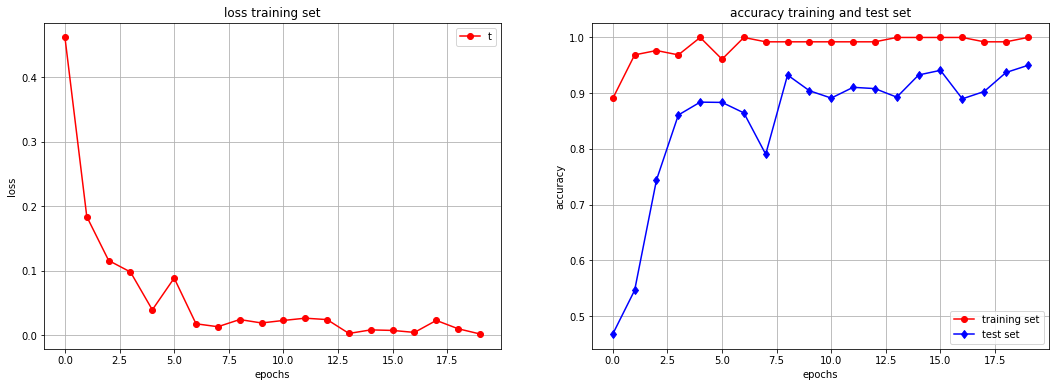

In [14]:
# Getting back the objects:
with open('training_history.pickle', 'rb') as f:  # Python 3: open(..., 'rb')
    history = pickle.load(f)
print(history)
fig = plt.figure(figsize=(18, 6)) #, subplot_kw={'xticks': [], 'yticks': []})
plt.subplot(1,2,1)
plt.plot(history['Losses'], 'ro-')
plt.title("loss training set")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid('on')

plt.legend('training set')

plt.subplot(1,2,2)
plt.plot(history['TrainAcc'], 'ro-')
plt.plot(history['TestAcc'], 'bd-')
plt.title("accuracy training and test set")
plt.legend(('training set', 'test set'))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid('on')


plt.show()